In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

def convert_seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return hours, minutes, seconds

start_time = time.time()

## Introduction
In this Notebook we show how to build a multiclass classifier, by:
 - applying simple pre-processing steps
 - trying different baseline algorithms
 - optimizing the hyperparameters of XGBoost
 
In the pre-processing steps, we convert the non numerical features using the LabelEncoding for most of the columns, i.e.for
the columns that have only two possible values or more than two sortable values. The only column that has not these characteristic is the MTRANS, where we apply the one-hot encoding.

Then we do some data exploration, analyzing the correlation between numerical features and labels, the distribution of train and test data, the distribution of labels, etc...

Then we train 4 different baseline classifier: RandomForest, GradientBoosting, LightGBM and XGBoost, XGBoost shows the best performance, so we decide to optimize
its hyperparameters by using the framework Optuna.

Finally we perfrom the predictions in two ways:

 - using all the training data.
 - using 5-fold stratified splitting and computing the average predicted probabilities out of 5


## 1. import data
We import the data and we create two subsets:
 - one with numerical data
 - one with categorical data

In [88]:
# train 데이터를 불러 옴.
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', index_col = 0)

['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


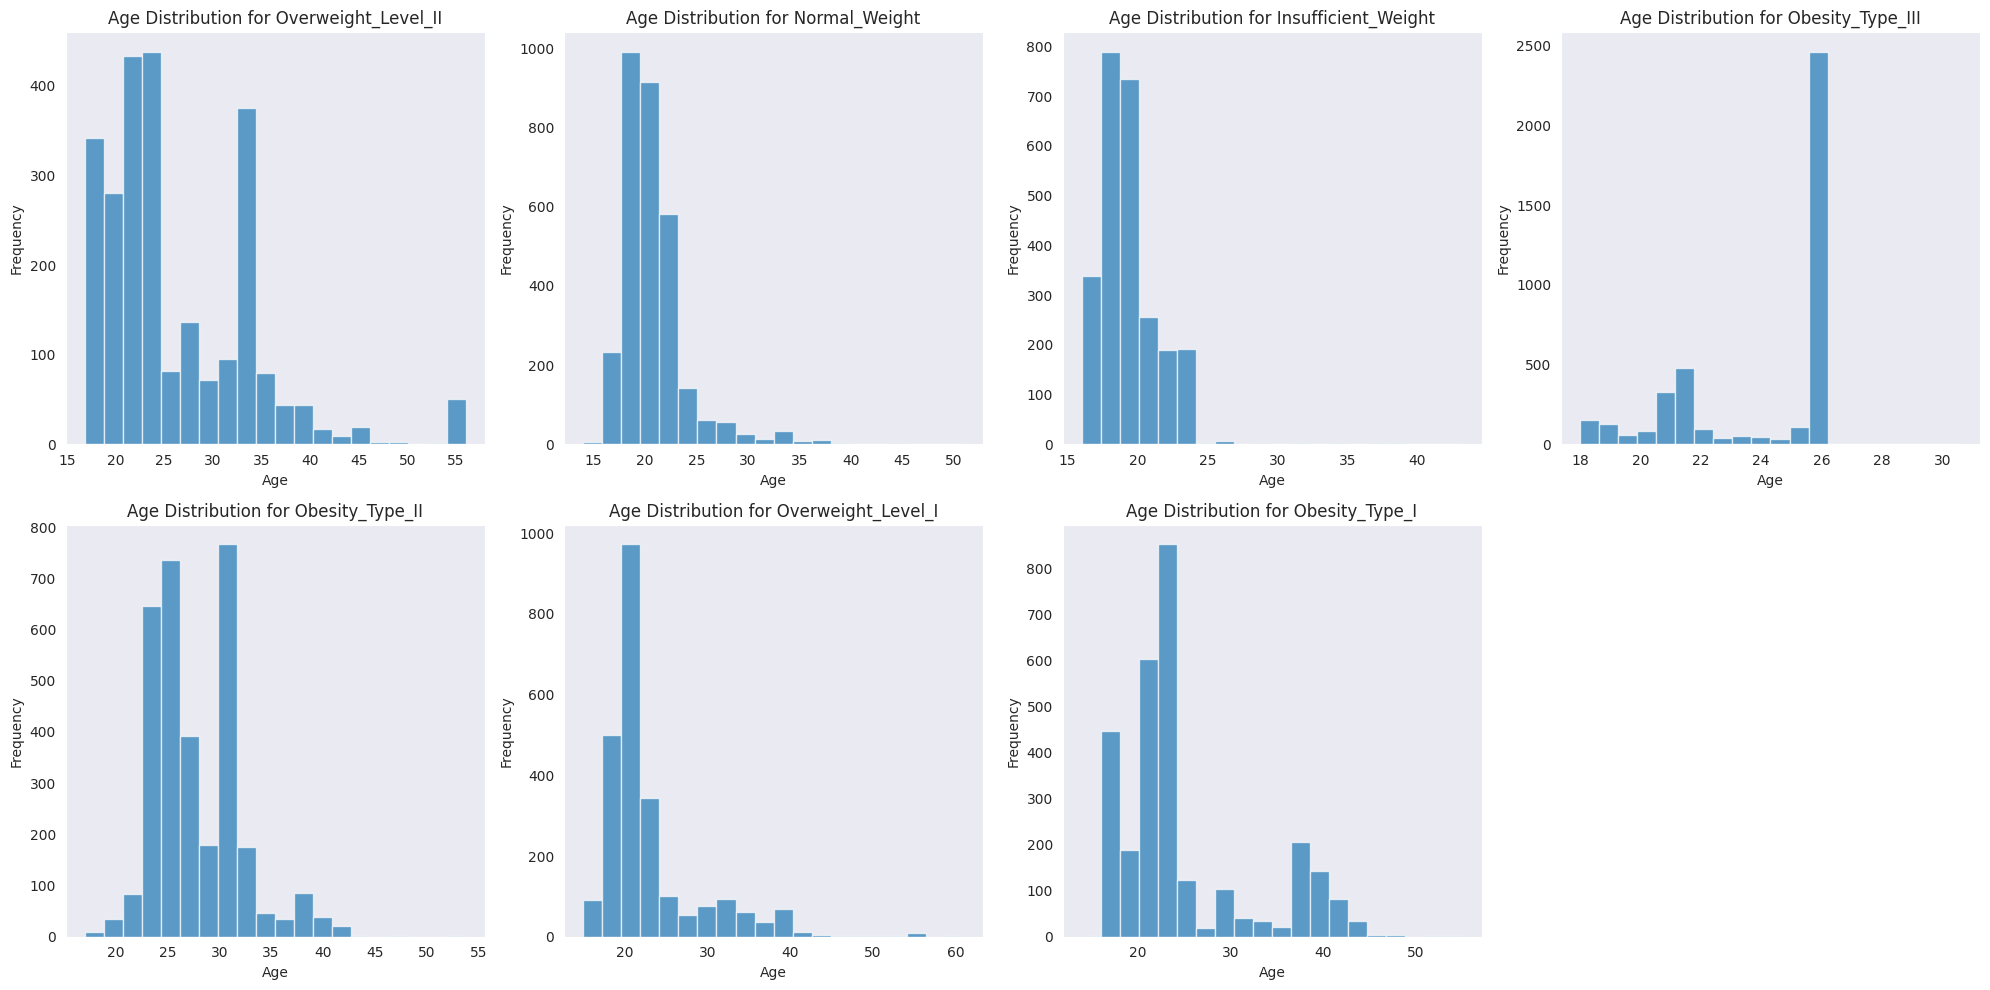

In [89]:
# 각 비만도 별로 나이 분포대 시각화
unique_categories = df['NObeyesdad'].unique()
print(unique_categories)
plt.figure(figsize=(20,10))

for i, category in enumerate(unique_categories, start=1):
    category_data = df[df['NObeyesdad'] == category]['Age']
    plt.subplot(2, 4, i)
    plt.hist(category_data, bins=20, alpha=0.7)
    plt.title(f'Age Distribution for {category}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    

plt.tight_layout()    
plt.show()

# train_data 결측치 없음을 확인.
df.isnull().sum()

In particular we can deduct that:

- 'Gender', 'Age', 'Height', 'Weight' are physical attributes
- 'family_history_with_overweight' points out to familiarity with obesity
- FAVC = Frequent consumption of high caloric food
- FCVC = Frequency of consumption of vegetables
- NCP = Number of main meals
- CAEC = Consumption of food between meals
- SMOKE = tobacco usage
- CH20 = Consumption of water daily
- SCC = Calories consumption monitoring
- FAF = Physical activity frequency
- TUE = Time using technology devices
-CALC = Consumption of alcohol
MTRANS = Transportation used

In [90]:
# train 데이터 X(features) 독립변수, y(labels) 종속변수 분리
labels = pd.DataFrame(df['NObeyesdad'])
features = df.drop('NObeyesdad', axis=1)

## 2.Data exploration and pre-processing

### Numerical DataFrame

In [91]:
# 독립 변수 중 숫자형 칼럼 분리. df_numerical은 정규화 하기 전의 숫자형 칼럼.
mask_numeric = features.dtypes == float
df_numerical = features.loc[:, mask_numeric]

df_numerical

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
id,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721
...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439


In [92]:
## 정규화 전 숫자형 칼럼의 평균과 분산
print('feature들의 평균 값')
print(df_numerical.mean())
print('\nfeature들의 분산 값')
print(df_numerical.var())

feature들의 평균 값
Age       23.841804
Height     1.700245
Weight    87.887768
FCVC       2.445908
NCP        2.761332
CH2O       2.029418
FAF        0.981747
TUE        0.616756
dtype: float64

feature들의 분산 값
Age        32.354163
Height      0.007623
Weight    695.875017
FCVC        0.284322
NCP         0.497553
CH2O        0.370232
FAF         0.702750
TUE         0.362541
dtype: float64


In [93]:
# 스케일 시작 -> StandardScaler 사용 -> TEST 1. 정규화 하고 안하고의 정확도 차이. 2. Standard vs min_max
from sklearn.preprocessing import StandardScaler


#객체 생성
scaler = StandardScaler()
scaler.fit(df_numerical)

numerical_scaled = scaler.transform(df_numerical)
df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

print('feature들의 평균 값')
print(df_numerical_scaled.mean())
print('\nfeature들의 분산 값')
print(df_numerical_scaled.var())


feature들의 평균 값
Age       1.889486e-16
Height   -1.107677e-15
Weight   -1.297310e-16
FCVC      1.095354e-16
NCP       1.762836e-17
CH2O     -2.931785e-16
FAF       3.902200e-17
TUE       1.328117e-16
dtype: float64

feature들의 분산 값
Age       1.000048
Height    1.000048
Weight    1.000048
FCVC      1.000048
NCP       1.000048
CH2O      1.000048
FAF       1.000048
TUE       1.000048
dtype: float64


In [94]:
# 이상치 파악 -> 이상치가 있긴 하지만 의미 있는 이상치이기에 제거하지 않음
import pandas as pd

# 각 숫자형 변수의 이상치 개수 계산
outliers = pd.DataFrame(index=df_numerical.columns, columns=["Has Outliers", "Outlier Count"])

for column in df_numerical.columns:
    Q1 = df_numerical[column].quantile(0.25)
    Q3 = df_numerical[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_count = ((df_numerical[column] < lower_bound) | (df_numerical[column] > upper_bound)).sum()
    
    outliers.loc[column, "Has Outliers"] = outlier_count > 0
    outliers.loc[column, "Outlier Count"] = outlier_count

print(outliers)


       Has Outliers Outlier Count
Age            True          1074
Height         True             4
Weight        False             0
FCVC          False             0
NCP            True          6052
CH2O          False             0
FAF           False             0
TUE           False             0


### Categorical DataFrame

In [95]:
# 범주형 칼럼만 추출하여 각 컬럼마다 원소 개수 확인
mask_categorical = features.dtypes != float
df_categorical = features.loc[:, mask_categorical]

for i in range(df_categorical.shape[1]):
    print(df_categorical.iloc[:, i].value_counts())


Gender
Female    10422
Male      10336
Name: count, dtype: int64
family_history_with_overweight
yes    17014
no      3744
Name: count, dtype: int64
FAVC
yes    18982
no      1776
Name: count, dtype: int64
CAEC
Sometimes     17529
Frequently     2472
Always          478
no              279
Name: count, dtype: int64
SMOKE
no     20513
yes      245
Name: count, dtype: int64
SCC
no     20071
yes      687
Name: count, dtype: int64
CALC
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64
MTRANS
Public_Transportation    16687
Automobile                3534
Walking                    467
Motorbike                   38
Bike                        32
Name: count, dtype: int64


## Encoding

In [96]:
# 범주형 칼럼 인코딩(Label encoding, one-hot encoding)

df_encoded = df_categorical.copy(deep=True)

# Label encoding
df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
df_encoded['family_history_with_overweight'] = df_encoded['family_history_with_overweight'].map({'no':0, 'yes':1})
df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes': 1, 'Frequently':2, 'Always':3})
# One-Hot encoding
df_onehot = pd.get_dummies(df_categorical['MTRANS']).astype(int)
df_encoded.drop('MTRANS', axis=1, inplace=True)

# concatenate
# one feature of df_encoded is redundant; we can remove it
df_encoded = pd.concat([df_encoded, df_onehot.iloc[:, :]], axis = 1)

df_encoded # 문자 -> 숫자 인코딩

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking
id,,,,,,,,,,,,
0,0,1,1,1,0,0,1,0,0,0,1,0
1,1,1,1,2,0,0,0,1,0,0,0,0
2,1,1,1,1,0,0,0,0,0,0,1,0
3,1,1,1,1,0,0,1,0,0,0,1,0
4,0,1,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0,1,1,1,0,0,1,0,0,0,1,0
20754,0,0,1,2,0,0,1,0,0,0,1,0
20755,0,1,1,1,0,0,0,0,0,0,1,0


### Concatenate all features together

In [97]:
# df_all_features는 스케일과 인코딩이 최종적으로 모두 끝난 독립변수 dataframe
df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

df_all_features

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking
0,0.105699,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438,0,1,1,1,0,0,1,0,0,0,1,0
1,-1.027052,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513,1,1,1,2,0,0,0,1,0,0,0,0
2,-1.027052,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239,1,1,1,1,0,0,0,0,0,0,1,0
3,-0.507929,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455,1,1,1,1,0,0,1,0,0,0,1,0
4,1.371197,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111,0,1,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.227725,0.760293,0.996987,0.888355,0.338364,0.201151,0.416056,-0.697686,0,1,1,1,0,0,1,0,0,0,1,0
20754,-1.027052,0.111729,-1.436296,1.039171,1.756085,-1.691863,1.214691,0.636513,0,0,1,2,0,0,1,0,0,0,1,0
20755,-0.657669,1.366537,0.670717,-0.071439,0.338364,-0.048349,0.210303,0.966092,0,1,1,1,0,0,0,0,0,0,1,0
20756,1.760067,-0.002805,-0.165574,0.422594,-1.119801,0.189694,-1.171141,0.593055,0,1,1,1,0,0,0,1,0,0,0,0


### Define a pre_processing pipeline
Let us summarize all the previous steps into a function, called 'apply_preprocessing'

In [98]:
# 위 전처리 코드를 파이프라인 함수 코드로 만듦 -> test 데이터의 독립변수 전처리할 때 사용할 예정
def apply_preprocessing(data):
    features = data.copy(deep=True)
    # numerical dataframe
    mask_numeric = features.dtypes == float
    df_numerical = features.loc[:, mask_numeric]
    
    # categorical dataframe
    mask_categorical = features.dtypes != float
    df_categorical = features.loc[:, mask_categorical]
    #객체 생성

    numerical_scaled = scaler.transform(df_numerical)
    df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

    # label encoding
    df_encoded = df_categorical.copy(deep=True)
    df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
    df_encoded['family_history_with_overweight'] = df_categorical['family_history_with_overweight'].map({'no':0, 'yes':1})
    df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
    df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
    df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
    df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})

    # one-hot encoding
    df_onehot = pd.get_dummies(df_categorical['MTRANS']).astype(int)
    df_encoded.drop('MTRANS', axis=1, inplace=True)
    
    # one feature of df_encoded is redundant; we can remove it
    df_encoded = pd.concat([df_encoded, df_onehot.iloc[:, :]], axis = 1)
    df_numerical_scaled.reset_index(drop=True, inplace=True)
    df_encoded.reset_index(drop=True, inplace=True)
    # concatenate
    # one feature of df_encoded is redundant; we can remove it
    df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

    
    return df_all_features


### Compare train and test dataset
The train dataset is that one that we will use to train the model. It has labels.
The test dataset will be used to make predictions and submit them to the competition.

In [99]:
# test 데이터를 불러옴. test 데이터 파일 전체가 종속 변수가 됨.
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', index_col = 0)

# 불러온 test를 위에서 만들어놓은 전처리 pipeline 함수 'apply_preprocessing'을 이용하여 인코딩과 스케일 적용
df_test = apply_preprocessing(df_test)

print('Train columns', df_all_features.columns)
print('Test columns', df_test.columns)
print(df_test.head())
assert all(df_test.columns == df_all_features.columns), "Column in train and test dataset must be the same"

Train columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation', 'Walking'],
      dtype='object')
Test columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation', 'Walking'],
      dtype='object')
        Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0  0.537644  1.695675  1.241770  0.924049  0.338364  1.308584 -0.150721   
1 -0.499620 -1.148152 -0.829748 -0.836279 -2.497077  1.595165  0.021775   
2  0.379434 -0.651587  0.898933  1.039171  0.338364  0.973714 -1.171141   
3 -0.503267 -1.685011  0.598259 -0.836279  0.307045  1.244138 -1.057992   
4  0.379434 -0.834373  0.642469  1.039171  0.338364  1.025

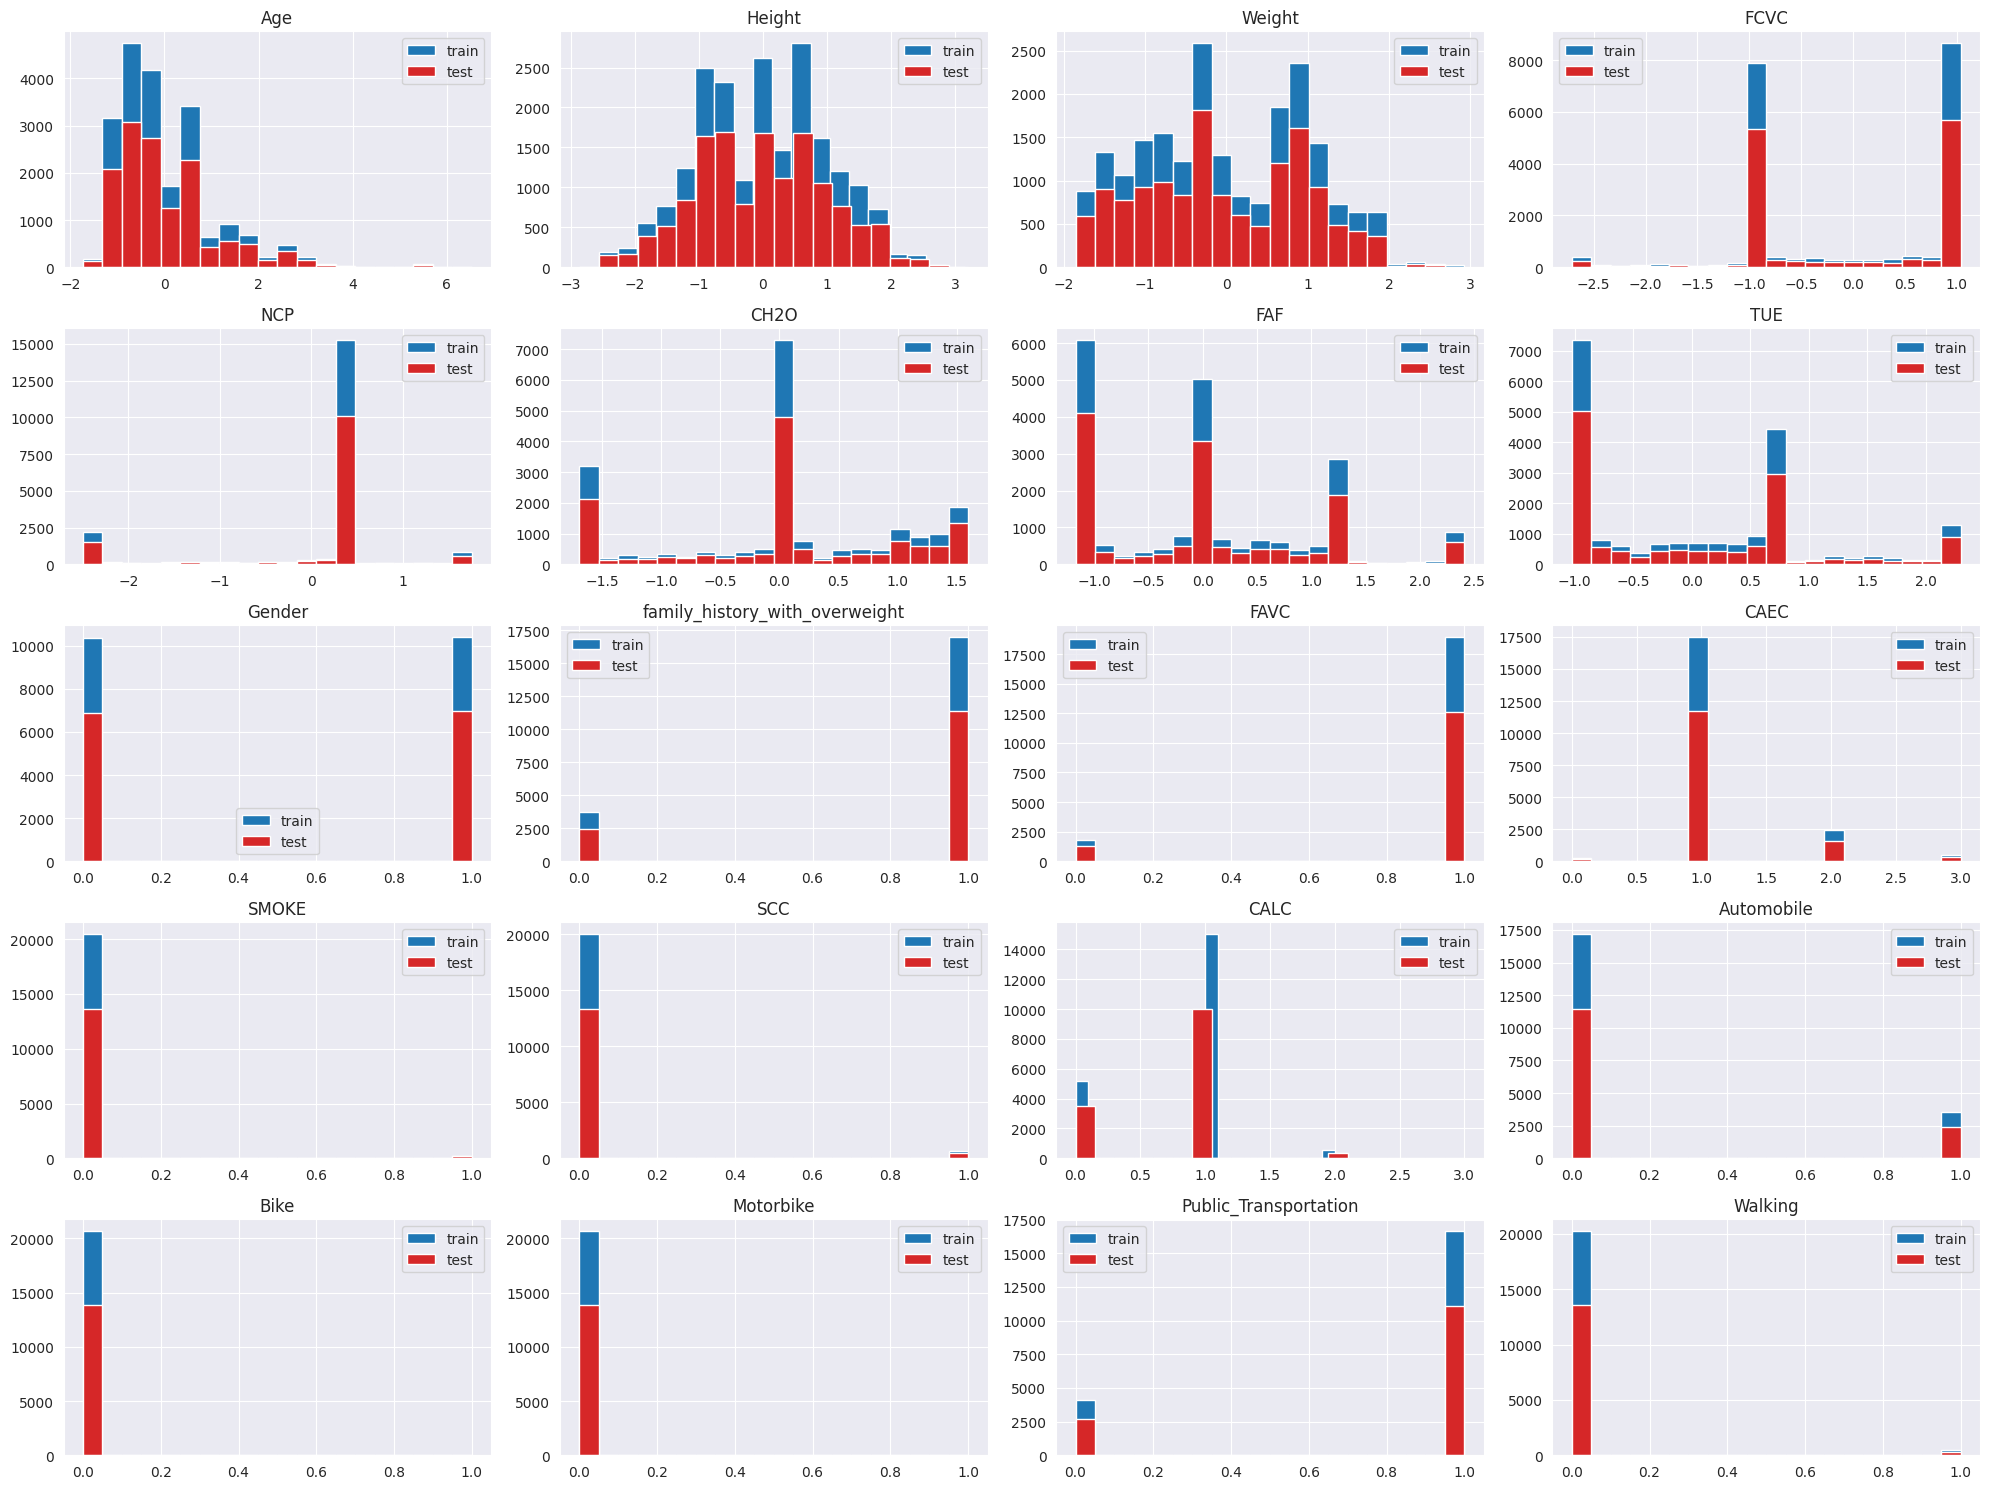

In [100]:
# 시각화 분포 필요없음
sns.set_style('dark')

plt.figure(figsize=(20, 15))

for i in range(df_all_features.shape[1]):
    plt.subplot(5, 4, i+1)
    plt.hist(df_all_features.iloc[:, i], bins=20, label='train')
    plt.hist(df_test.iloc[:, i], bins=20,
             alpha=1, label='test', color='C3')
    plt.title(df_all_features.columns[i])
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

### Labels

In [101]:
# labels는 train데이터의 종속 변수
labels['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [102]:
# labels의 값을 인코딩 함
labels_encoded = labels.copy(deep=True)

dict_conversion = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}

labels_encoded['NObeyesdad'] = labels_encoded['NObeyesdad'].map(dict_conversion)
labels_encoded.value_counts()


NObeyesdad
6             4046
5             3248
1             3082
4             2910
0             2523
3             2522
2             2427
Name: count, dtype: int64

In [103]:
# # train 데이터의 종속변수 분포도 시각화 확인
# sns.set_style('dark')

# plt.figure(figsize=(10,6))
# plt.hist(labels_encoded, bins=np.arange(0, 8)-0.25, width=0.5, align='mid')
# plt.grid()
# plt.xticks(np.arange(0, 6.1),
#           ['Insufficient', 'Normal', 'Overweight I', 'Overweight II', 'Obesity I', 'Obesity II', 'Obesity III'],
#           rotation= 90)

# plt.ylabel('Frequency')
# plt.show()

## 3.Prepare data for machine learning

In [104]:
# X는 train 데이터의 독립변수 y는 train 데이터의 종속변수
X = df_all_features.loc[: , ["Age", "Weight",'TUE', "FCVC", "CH2O",  "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "Automobile", "Bike", "Motorbike", "Public_Transportation", "Walking"]]
# 머신러닝 모델을 훈련할 때는 대부분의 경우 np.ravel()을 사용하여 타겟 변수를 1차원 배열로 변환하는 것이 안전함.
y = np.ravel(labels_encoded)

# compare train and test data
# X_test는 test 데이터의 독립변수
X_test = df_test.loc[: , ["Age", "Weight", 'TUE',"FCVC", "CH2O",   "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "Automobile", "Bike", "Motorbike", "Public_Transportation", "Walking"]]
assert all(X_test.columns == X.columns), "Columns of trainging and test data must be the same"

print('Number of samples', len(X))
print('Number of featires', X.shape[1])

from sklearn.model_selection import train_test_split

# train 데이터를 나눠주어 검증 데이터를 만들어 줌.
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Number of samples 20758
Number of featires 17


## Fit the data with baseline models

In [105]:
# 일단은 4개의 모델을 기본값으로 사용하여 정확도를 측정해본다!
# 그래디언트 부스트, 랜덤, LGBM, XGB 사용
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier(class_weight='balanced')
clf3 = LGBMClassifier(class_weight='balanced')
clf4 = XGBClassifier()

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1296
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 17
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [106]:
# X_train과 X_validation을 사용하여 정확도를 평가하는 함수.
def evaluate_model(clf):
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_validation)
    train_score = np.mean(y_pred_train == y_train)
    validation_score = np.mean(y_pred_test == y_validation)
    
    print('Train score', round(train_score, 3))
    print('Test score', round(validation_score, 3))
    
    if train_score - validation_score > 0.05:
        print('Overfitting detected')
    
    print('=========================================')

In [107]:
print('Random Forest')
evaluate_model(clf2)

print('LightGBM')
evaluate_model(clf3)

print('Gradient Boosting')
evaluate_model(clf1)

print('XGBoost')
evaluate_model(clf4)

Random Forest
Train score 0.991
Test score 0.859
Overfitting detected
LightGBM
Train score 0.948
Test score 0.873
Overfitting detected
Gradient Boosting
Train score 0.891
Test score 0.876
XGBoost
Train score 0.955
Test score 0.874
Overfitting detected


## 5. Hyperparameter tuning
We fine_tune the XGBoost Classifier, LightGBM defined in the previous section, using the optimizer framework called Optuna

In [108]:
# 하이퍼파라미터 튜닝(여기서 XGBoost와 LightGBM 파라미터 튜닝을 한 번에 함 -> 시간 오래 걸림)
import optuna
from sklearn.model_selection import cross_validate

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 4, 10)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0, 1)
    
    print('Training the model with', X.shape[1], 'features')
    
    # XGBoost 
    if trial.suggest_categorical('model', ['xgboost', 'lightgbm']) == 'xgboost':
        params = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'gamma': gamma,
                  'reg_alpha': reg_alpha,
                  'reg_lambda': reg_lambda,
                  'max_depth': max_depth,
                  'min_child_weight': min_child_weight,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'eval_metric':'mlogloss'}

        clf = XGBClassifier(**params)
   
    # LightGBM
    else:
        params = {'learning_rate': learning_rate,
                  'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'lambda_l1': reg_alpha,
                  'lambda_l2': reg_lambda,
                  'colsample_bytree': colsample_bytree, 
                  'subsample': subsample,    
                  'min_child_samples': min_child_weight,
                  'class_weight': 'balanced'}

        clf = LGBMClassifier(**params, verbose = -1, verbosity = -1)
    
    # 교차검증까지 함.
    cv_results = cross_validate(clf, X, y, cv=5, scoring='accuracy')
    
    validation_score = np.mean(cv_results['test_score'])
    
    return validation_score

In [109]:
# Uncomment this section if you want to do hyperparameter tuning
# 하이퍼파라미터 튜닝 시작 코드
# n_trials가 반복 횟수
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

[I 2024-02-27 13:58:36,129] A new study created in memory with name: no-name-774a17b2-078d-4a28-a8f5-da8160db6e29


Training the model with 17 features


[I 2024-02-27 14:00:07,445] Trial 0 finished with value: 0.8614992951532445 and parameters: {'max_depth': 7, 'n_estimators': 1535, 'gamma': 0.21215212385606086, 'reg_alpha': 0.16248343044911595, 'reg_lambda': 0.6644746372853391, 'min_child_weight': 7, 'subsample': 0.5347986906044476, 'colsample_bytree': 0.2434703905556248, 'learning_rate': 0.24901267524833814, 'model': 'lightgbm'}. Best is trial 0 with value: 0.8614992951532445.


Training the model with 17 features


[I 2024-02-27 14:00:41,499] Trial 1 finished with value: 0.8568264303840243 and parameters: {'max_depth': 5, 'n_estimators': 899, 'gamma': 0.5765344523117935, 'reg_alpha': 0.874747019461075, 'reg_lambda': 0.9954931435231144, 'min_child_weight': 5, 'subsample': 0.04763067053653747, 'colsample_bytree': 0.8797781591339986, 'learning_rate': 0.8058474663940145, 'model': 'lightgbm'}. Best is trial 0 with value: 0.8614992951532445.


Training the model with 17 features


[I 2024-02-27 14:01:12,442] Trial 2 finished with value: 0.8595243897401049 and parameters: {'max_depth': 8, 'n_estimators': 903, 'gamma': 0.2911847063972657, 'reg_alpha': 0.86126366653491, 'reg_lambda': 0.32985104074877925, 'min_child_weight': 5, 'subsample': 0.822733352683793, 'colsample_bytree': 0.41534865368824003, 'learning_rate': 0.905601622466886, 'model': 'lightgbm'}. Best is trial 0 with value: 0.8614992951532445.


Training the model with 17 features


[I 2024-02-27 14:01:46,772] Trial 3 finished with value: 0.8759033503545586 and parameters: {'max_depth': 5, 'n_estimators': 762, 'gamma': 0.8775304525794276, 'reg_alpha': 0.4982922131736899, 'reg_lambda': 0.4976750205536927, 'min_child_weight': 10, 'subsample': 0.7806398293540874, 'colsample_bytree': 0.13587113627747993, 'learning_rate': 0.10718749376641701, 'model': 'lightgbm'}. Best is trial 3 with value: 0.8759033503545586.


Training the model with 17 features


[I 2024-02-27 14:02:28,630] Trial 4 finished with value: 0.865256961551155 and parameters: {'max_depth': 8, 'n_estimators': 1344, 'gamma': 0.092570494918358, 'reg_alpha': 0.8985776065607403, 'reg_lambda': 0.42073986239378125, 'min_child_weight': 4, 'subsample': 0.39753042832195307, 'colsample_bytree': 0.3251004914829849, 'learning_rate': 0.7267807139778331, 'model': 'lightgbm'}. Best is trial 3 with value: 0.8759033503545586.


Training the model with 17 features


[I 2024-02-27 14:03:27,325] Trial 5 finished with value: 0.8773966994512084 and parameters: {'max_depth': 5, 'n_estimators': 725, 'gamma': 0.8030807928151988, 'reg_alpha': 0.7811315064807591, 'reg_lambda': 0.13995576609876503, 'min_child_weight': 1, 'subsample': 0.3018282159276473, 'colsample_bytree': 0.19860313457476297, 'learning_rate': 0.22722328481883836, 'model': 'xgboost'}. Best is trial 5 with value: 0.8773966994512084.


Training the model with 17 features


[I 2024-02-27 14:07:01,369] Trial 6 finished with value: 0.8601020530837568 and parameters: {'max_depth': 6, 'n_estimators': 1868, 'gamma': 0.005760735949526086, 'reg_alpha': 0.5766215900024733, 'reg_lambda': 0.4700372770196596, 'min_child_weight': 2, 'subsample': 0.9624517270532504, 'colsample_bytree': 0.8438754683466058, 'learning_rate': 0.28800748700296364, 'model': 'xgboost'}. Best is trial 5 with value: 0.8773966994512084.


Training the model with 17 features


[I 2024-02-27 14:07:59,818] Trial 7 finished with value: 0.8563447348156235 and parameters: {'max_depth': 8, 'n_estimators': 1603, 'gamma': 0.5385555485765215, 'reg_alpha': 0.21279385429736652, 'reg_lambda': 0.5945310122312386, 'min_child_weight': 7, 'subsample': 0.8144666891971161, 'colsample_bytree': 0.1480714402341764, 'learning_rate': 0.7628452544753715, 'model': 'lightgbm'}. Best is trial 5 with value: 0.8773966994512084.


Training the model with 17 features


[I 2024-02-27 14:11:03,047] Trial 8 finished with value: 0.8719532030028281 and parameters: {'max_depth': 7, 'n_estimators': 1664, 'gamma': 0.07907179655388841, 'reg_alpha': 0.5188429653557741, 'reg_lambda': 0.7827677317448446, 'min_child_weight': 2, 'subsample': 0.7607434143094257, 'colsample_bytree': 0.2511742463116864, 'learning_rate': 0.0871510849551771, 'model': 'xgboost'}. Best is trial 5 with value: 0.8773966994512084.


Training the model with 17 features


[I 2024-02-27 14:12:01,117] Trial 9 finished with value: 0.8567778082584738 and parameters: {'max_depth': 10, 'n_estimators': 1874, 'gamma': 0.4785652461249047, 'reg_alpha': 0.6346978086866034, 'reg_lambda': 0.18819169210095388, 'min_child_weight': 2, 'subsample': 0.9122595906628619, 'colsample_bytree': 0.3549282468685738, 'learning_rate': 0.9207772097699141, 'model': 'lightgbm'}. Best is trial 5 with value: 0.8773966994512084.


Training the model with 17 features


[I 2024-02-27 14:12:59,448] Trial 10 finished with value: 0.7955480583873978 and parameters: {'max_depth': 4, 'n_estimators': 512, 'gamma': 0.9618820973088839, 'reg_alpha': 0.3418839600102354, 'reg_lambda': 0.04892680087175284, 'min_child_weight': 0, 'subsample': 0.08341921918243422, 'colsample_bytree': 0.6105337143252946, 'learning_rate': 0.4924171783432495, 'model': 'xgboost'}. Best is trial 5 with value: 0.8773966994512084.


Training the model with 17 features


[I 2024-02-27 14:13:55,555] Trial 11 finished with value: 0.8096640129894184 and parameters: {'max_depth': 4, 'n_estimators': 656, 'gamma': 0.9524233361755057, 'reg_alpha': 0.6974928232421405, 'reg_lambda': 0.00307807627128745, 'min_child_weight': 10, 'subsample': 0.30906512101962713, 'colsample_bytree': 0.022499124698883877, 'learning_rate': 0.018502816074858708, 'model': 'xgboost'}. Best is trial 5 with value: 0.8773966994512084.


Training the model with 17 features


[I 2024-02-27 14:15:12,355] Trial 12 finished with value: 0.8671837090117801 and parameters: {'max_depth': 5, 'n_estimators': 1008, 'gamma': 0.743846271549881, 'reg_alpha': 0.378909263100988, 'reg_lambda': 0.24086445726811284, 'min_child_weight': 10, 'subsample': 0.571879600555997, 'colsample_bytree': 0.04829303396798315, 'learning_rate': 0.24755905894695604, 'model': 'xgboost'}. Best is trial 5 with value: 0.8773966994512084.


Training the model with 17 features


[I 2024-02-27 14:16:59,674] Trial 13 finished with value: 0.8636669832326774 and parameters: {'max_depth': 5, 'n_estimators': 1134, 'gamma': 0.7695414249042072, 'reg_alpha': 0.7464872242841676, 'reg_lambda': 0.7847577667576496, 'min_child_weight': 8, 'subsample': 0.21194898781035898, 'colsample_bytree': 0.5932265089825186, 'learning_rate': 0.4398368461431278, 'model': 'xgboost'}. Best is trial 5 with value: 0.8773966994512084.


Training the model with 17 features


[I 2024-02-27 14:17:33,631] Trial 14 finished with value: 0.8732537230158808 and parameters: {'max_depth': 6, 'n_estimators': 717, 'gamma': 0.8073618068972005, 'reg_alpha': 0.4476544708988463, 'reg_lambda': 0.20622370272169066, 'min_child_weight': 0, 'subsample': 0.6737275623780724, 'colsample_bytree': 0.13411415006223093, 'learning_rate': 0.138142171630175, 'model': 'lightgbm'}. Best is trial 5 with value: 0.8773966994512084.


In [110]:
# 하이퍼파라미터 결과 출력
# 정확도가 높은 순서대로 나옴
df_study = study.trials_dataframe()
df_study = df_study.sort_values(by='value', ascending=False)

df_study

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_model,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample,state
5,5,0.877397,2024-02-27 14:02:28.631254,2024-02-27 14:03:27.325294,0 days 00:00:58.694040,0.198603,0.803081,0.227223,5,1,xgboost,725,0.781132,0.139956,0.301828,COMPLETE
3,3,0.875903,2024-02-27 14:01:12.443433,2024-02-27 14:01:46.771468,0 days 00:00:34.328035,0.135871,0.877530,0.107187,5,10,lightgbm,762,0.498292,0.497675,0.780640,COMPLETE
14,14,0.873254,2024-02-27 14:16:59.675816,2024-02-27 14:17:33.630858,0 days 00:00:33.955042,0.134114,0.807362,0.138142,6,0,lightgbm,717,0.447654,0.206224,0.673728,COMPLETE
8,8,0.871953,2024-02-27 14:07:59.819321,2024-02-27 14:11:03.046438,0 days 00:03:03.227117,0.251174,0.079072,0.087151,7,2,xgboost,1664,0.518843,0.782768,0.760743,COMPLETE
12,12,0.867184,2024-02-27 14:13:55.557151,2024-02-27 14:15:12.354509,0 days 00:01:16.797358,0.048293,0.743846,0.247559,5,10,xgboost,1008,0.378909,0.240864,0.571880,COMPLETE
4,4,0.865257,2024-02-27 14:01:46.772835,2024-02-27 14:02:28.629602,0 days 00:00:41.856767,0.325100,0.092570,0.726781,8,4,lightgbm,1344,0.898578,0.420740,0.397530,COMPLETE
13,13,0.863667,2024-02-27 14:15:12.355875,2024-02-27 14:16:59.673543,0 days 00:01:47.317668,0.593227,0.769541,0.439837,5,8,xgboost,1134,0.746487,0.784758,0.211949,COMPLETE
0,0,0.861499,2024-02-27 13:58:36.131315,2024-02-27 14:00:07.444601,0 days 00:01:31.313286,0.243470,0.212152,0.249013,7,7,lightgbm,1535,0.162483,0.664475,0.534799,COMPLETE
6,6,0.860102,2024-02-27 14:03:27.326923,2024-02-27 14:07:01.368979,0 days 00:03:34.042056,0.843875,0.005761,0.288007,6,2,xgboost,1868,0.576622,0.470037,0.962452,COMPLETE
2,2,0.859524,2024-02-27 14:00:41.500460,2024-02-27 14:01:12.441576,0 days 00:00:30.941116,0.415349,0.291185,0.905602,8,5,lightgbm,903,0.861264,0.329851,0.822733,COMPLETE


In [111]:
# XGBoost 최적 하이퍼파라미터 출력
print("Best params for XGBoost:")
xgboost_params = df_study[df_study['params_model'] == 'xgboost'].iloc[0]
xgboost_params.pop('number')  # 'number' 키 제거
xgboost_params.pop('value')  # 'value' 키 제거
xgboost_params.pop('datetime_start')  # 'datetime_start' 키 제거
xgboost_params.pop('datetime_complete')  # 'datetime_complete' 키 제거
xgboost_params.pop('duration')  # 'duration' 키 제거
xgboost_params.pop('state')  # 'state' 키 제거
xgboost_params.pop('params_model')


best_params_XGB = {key.replace('params_',''): value for key, value in xgboost_params.items()}
print(best_params_XGB)

# LightGBM 최적 하이퍼파라미터 출력
print("\nBest params for LightGBM:")
lightgbm_params = df_study[df_study['params_model'] == 'lightgbm'].iloc[0]
lightgbm_params.pop('number')  # 'number' 키 제거
lightgbm_params.pop('value')  # 'value' 키 제거
lightgbm_params.pop('datetime_start')  # 'datetime_start' 키 제거
lightgbm_params.pop('datetime_complete')  # 'datetime_complete' 키 제거
lightgbm_params.pop('duration')  # 'duration' 키 제거
lightgbm_params.pop('state')  # 'state' 키 제거
lightgbm_params.pop('params_model')

best_params_LGBM = {key.replace('params_', ''):value for key, value in lightgbm_params.items()}
best_params_LGBM

Best params for XGBoost:
{'colsample_bytree': 0.19860313457476297, 'gamma': 0.8030807928151988, 'learning_rate': 0.22722328481883836, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 725, 'reg_alpha': 0.7811315064807591, 'reg_lambda': 0.13995576609876503, 'subsample': 0.3018282159276473}

Best params for LightGBM:


{'colsample_bytree': 0.13587113627747993,
 'gamma': 0.8775304525794276,
 'learning_rate': 0.10718749376641701,
 'max_depth': 5,
 'min_child_weight': 10,
 'n_estimators': 762,
 'reg_alpha': 0.4982922131736899,
 'reg_lambda': 0.4976750205536927,
 'subsample': 0.7806398293540874}

Also hyperparameters for LightGBM Classifier have been optimized. In case you want to test it, please un comment the following cell.

## 6. Train the best model and export the results( 안 해도 됨)

# 7. 스태킹

In [ ]:
# 스태킹에 사용할 CatBoost 최적의 파라미터 찾는 코드
def objective(trial):
    
    param = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.2),
        'random_strength': trial.suggest_int('random_strength', 0, 50),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.00),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.5, 5.0),
        'loss_function': 'MultiClass' 
    }

    
    clf = CatBoostClassifier(**param, verbose=False)
    
    cv_results = cross_validate(clf, X, y, cv=5, scoring='accuracy')
    
    validation_score = np.mean(cv_results['test_score'])
    
    return validation_score
    


study_cat = optuna.create_study(direction='maximize')
# 반복횟수 조정
study_cat.optimize(objective, n_trials=5)



[I 2024-02-27 14:17:33,694] A new study created in memory with name: no-name-3572e070-9753-4885-97c0-afc78c46a1cf
/tmp/ipykernel_33/1104234157.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.2),
/tmp/ipykernel_33/1104234157.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.00),
/tmp/ipykernel_33/1104234157.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2

In [ ]:
df_study_cat = study_cat.trials_dataframe()
df_study_cat = df_study_cat.sort_values(by='value', ascending=False)

#df_study_cat 최적의 파라미터 출력
best_params_cat = study_cat.best_params
best_params_cat

In [ ]:
# 스태킹에서 base 모델로 사용할 모델들 모음
base_models = [
    ('xgboost', XGBClassifier(**best_params_XGB)),
    ('lightgbm', LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity=-1)),
    ('catboost', CatBoostClassifier(**best_params_cat)),    
]

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)
# 추정기로 위 3가지 모델, 마지막 추정기로 로지스틱 회귀 사용
stacking_model = StackingClassifier(estimators=base_models, final_estimator=XGBClassifier(**best_params_XGB))
# 최종 스태킹 모델 학습
stacking_model.fit(X_train, y_train)

In [ ]:
# 최종 스태킹 모델 정확도 예상(검증 데이터 활용)
from sklearn.metrics import accuracy_score
y_pred_val = stacking_model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_pred_val)
print(accuracy_val)

In [ ]:
# 최종 스태킹 모델로 test 데이터의 종속변수 예상
y_pred_test = stacking_model.predict(X_test)
y_pred_test[:10]

In [ ]:
# 제출을 위한 변환
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
df_submission['NObeyesdad'] = y_pred_test
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.set_index('id', inplace=True)
print(df_submission)
df_submission.to_csv('submission.csv')

#밑에서 교차검증 하고 최종 제출할 예정
end_time = time.time()
hours, minutes, seconds = convert_seconds_to_hms(end_time - start_time)

# 최종 확인
print(f"학습시간 : {end_time - start_time} 초")
print(f"{hours} 시간, {minutes} 분, {seconds} 초")

## 7. Try to improve accuracy using cross validation
In this section we use a tuned XGBoost together with cross-validation. We make 5 predictions for each sample and then we compute the average probability to assign the label

In [ ]:
# # StratifiedKFold로 교차검증을 해보자
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import accuracy_score

# def train_evaluate_model(X, y, X_test, stacking_model):
#     # use Stratified KFold
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     skf.get_n_splits(X, y)

#     scores = []
#     predictions = []
#     clfs = []

#     for i, (train_index, val_index) in enumerate(skf.split(X, y)):
#         print('Fitting with k-fold', i+1, 'out of', len(train_index))
#         X_train = np.array(X)[train_index, :]
#         y_train = np.array(y)[train_index]
#         X_val = np.array(X)[val_index, :]
#         y_val = np.array(y)[val_index]
        
#         print('Training on', len(X_train), 'samples')
#         print('Evaluating on', len(X_val), 'samples')
        
#         stacking_model.fit(X_train, y_train)
        
#         y_pred_val = stacking_model.predict(X_val)

#         new_score = accuracy_score(y_val, y_pred_val)
#         print('validation score is', new_score)
#         scores.append(new_score)

#         # store predictions
#         y_pred_test = stacking_model.predict(X_test)
#         predictions.append(y_pred_test)
#         print('Round', i+1, 'Predictions stored successfully')
        
#         clfs.append(stacking_model)
        
#     return scores, np.array(predictions), clfs

In [ ]:
# scores, predictions, clfs = train_evaluate_model(X, y, X_test, stacking_model)

In [ ]:
# print('Average evaluation score = ', np.mean(scores))

In [ ]:
# y_test_pred = np.mean(predictions, axis=0)

# y_test_pred

In [ ]:
# df_submission['NObeyesdad'] = y_test_pred
# df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

In [ ]:
# 스태킹-교차검증 찐찐찐최종 제출 파일
#df_submission.set_index('id', inplace=True)
# print(df_submission)
# df_submission.isnull().sum()
#df_submission.to_csv('submission.csv')

Explore results of one of the model previously trained

## 8. Try to improve accuracy using cross validation(혹시나 스태킹이 아닌 보팅을 사용할 경우 이거 사용! / 보팅 알고리즘으로 lgbm, xgb, gb 사용)
In this section we try to improve the accuracy using a voting classifier, consisting of the 3 following algorithms:

- GradientBoosting Classifier
- XGBoost
- LigthGBM

In [ ]:
# from sklearn.ensemble import VotingClassifier

# clf_lgbm = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
# clf_xgb = XGBClassifier(**best_params_XGB)
# clf_cb = CatBoostClassifier(**best_params_cat)  
# voting_clf = VotingClassifier(estimators=[('lgbm', clf_lgbm), ('xgb', clf_xgb), ('cb', clf_cb)], 
#                               voting='soft')

# voting_clf.fit(X, y)

In [ ]:
# df_submission['NObeyesdad'] = voting_clf.predict(X_test)
# df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)


# print(df_submission)

# df_submission.to_csv('submission.csv')